## Installing the relevant libraries.

In [ ]:
!pip install tqdm
!pip install transformers datasets
!pip install torchinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

## Importing the packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from datasets import Array3D, ClassLabel, Features, load_dataset
from matplotlib import pyplot
from numpy import inf
from sklearn.utils.class_weight import compute_class_weight
from torchinfo import summary
from tqdm import tqdm
from transformers import AdamW, ViTFeatureExtractor, ViTModel

## Downloading the data and preparing the train, validation and test datasets

Here we import a small portion of CIFAR-10 dataset

In [ ]:
ls

sample_data/


In [ ]:
# load cifar10 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Feature Extractor

We are using `ViTFeatureExtractor`. This feature extractor will  resize/rescale the images to the same resolution (224x224) and normalize them across the RGB channels with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5).

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

(32, 32, 3)
cat


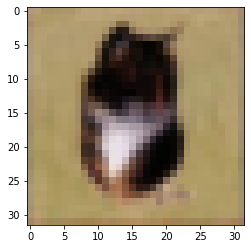

In [ ]:
chk = train_ds[67]
a = np.array(chk['img'])
print(a.shape)
cats = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


print(cats[chk['label']])
pyplot.imshow(a, cmap=pyplot.get_cmap('gray'))

## Preprocess Images
The preprocess_images function is used to process each image in the dataset. These processed images will be fed to the model

In [ ]:
def preprocess_images(examples):
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']
    return examples

HuggingFace Datasets .map(function, batched=True) functionality is used apply the preprocess_images function on every item in the dataset

In [ ]:
from datasets import Image

In [ ]:
import pandas as pd

In [ ]:
type(train_ds['img'][1])

PIL.PngImagePlugin.PngImageFile

In [ ]:
teste = np.array(train_ds['img'][1])

In [ ]:
teste

array([[[ 53,  38,  23],
        [ 56,  39,  19],
        [ 68,  48,  24],
        ...,
        [ 72, 118, 144],
        [ 75, 131, 166],
        [ 76, 137, 176]],

       [[ 52,  35,  22],
        [ 65,  47,  25],
        [ 74,  54,  25],
        ...,
        [ 69, 104, 129],
        [ 70, 125, 156],
        [ 67, 130, 166]],

       [[ 43,  30,  18],
        [ 51,  37,  20],
        [ 63,  46,  22],
        ...,
        [ 78, 114, 141],
        [ 75, 124, 151],
        [ 63, 122, 157]],

       ...,

       [[125, 173, 190],
        [140, 173, 191],
        [139, 178, 194],
        ...,
        [ 47,  35,  18],
        [ 32,  19,  12],
        [ 65,  35,  17]],

       [[168, 203, 211],
        [188, 209, 219],
        [191, 218, 224],
        ...,
        [ 35,  31,  16],
        [ 26,  14,   3],
        [ 96,  54,  20]],

       [[182, 214, 219],
        [192, 209, 216],
        [182, 205, 209],
        ...,
        [ 31,  20,   5],
        [ 36,  21,   9],
        [118,  70,  28]]

In [ ]:
# we need to define the features ourselves as both the img and pixel_values have a 3D shape 
features = Features({
    'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
    #'img': Array3D(dtype="int64", shape=(3,32,32)),
    'img': Image(decode=True, id=None),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, features=features)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
# set format to PyTorch
preprocessed_train_ds.set_format('torch', columns=['pixel_values', 'label'])
preprocessed_val_ds.set_format('torch', columns=['pixel_values', 'label'])
preprocessed_test_ds.set_format('torch', columns=['pixel_values', 'label'])

In [ ]:
preprocessed_train_ds

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 4500
})

## Preparing the train, validation and test data loaders

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create dataloaders
train_batch_size = 10
eval_batch_size = 10
train_dataloader = torch.utils.data.DataLoader(preprocessed_train_ds, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(preprocessed_val_ds, batch_size=eval_batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(preprocessed_test_ds, batch_size=eval_batch_size, num_workers=2)
batch = next(iter(train_dataloader))

In [ ]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['label'].shape == (train_batch_size,)

## Define the model

Here we are using Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

https://huggingface.co/google/vit-base-patch16-224-in21k

In [ ]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
for param in vit_model.parameters():
      param.requires_grad = False

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(ViTForImageClassification, self).__init__()
        self.vit = vit_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits

In [ ]:
model = ViTForImageClassification()
model = model.to(device)
# summary(model)

## Computing the class weights to handle the data imbalance

In [ ]:
Y_label = preprocessed_train_ds['label'].numpy()

In [ ]:
Y_label

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(Y_label), y= Y_label)

In [ ]:
 
# # convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# # loss function
cross_entropy = nn.CrossEntropyLoss(weight=weights)

## Setting the Optimizer and Epochs

In [ ]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# number of training epochs
epochs = 2

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Model Train function
It is to train the train dataloader

In [ ]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
        
        # push the batch to gpu
        lbl, pix = batch.items()
        lbl, pix = lbl[1].to(device), pix[1].to(device)
        
        # get model predictions for the current batch
        preds = model(pix)
       
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, lbl)
        
        # add on to the total loss
        total_loss = total_loss + loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # clear calculated gradients
        optimizer.zero_grad()  
        preds=preds.detach().cpu().numpy()
        
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    total_preds  = np.concatenate(total_preds, axis=0)
    
    #returns the loss and predictions
    return avg_loss, total_preds

## Model Eval function
It is to evaluate the validation dataloader

In [ ]:
def eval():
    total_loss = 0
    model.eval() # prep model for evaluation
    for step,batch in enumerate(val_dataloader):
        lbl, pix = batch.items()
        lbl, pix = lbl[1].to(device), pix[1].to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        preds = model(pix)
        # calculate the loss
        loss = cross_entropy(preds, lbl)
        total_loss += loss.item()
    
    return total_loss / len(val_dataloader)

## Training the model 

Training and checking the training loss on train data loader and validation loss on validation data loader 

In [ ]:
min_loss = inf
es = 0
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    val_loss = eval()
    
    # Early Stopping
    if val_loss < min_loss:
        min_loss = val_loss
        es = 0
    else:
        es += 1
        if es > 4:
            print("Early stopping with train_loss: ", train_loss, "and val_loss for this epoch: ", val_loss, "...")
            break
    
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f'\n Validation Loss: {val_loss:.3f}')

## Save the model weights

In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/model')

## Load the model weights

In [ ]:
# model = ViTForImageClassification()
# model.load_state_dict(torch.load('/kaggle/working/model'), strict=False)

# # push the model to GPU
# model = model.to(device)
summary(model)

## Testing the model on Test DataLoader

In [ ]:
def eval():
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
            lbl, pix = batch.items()
            lbl, pix = lbl[1].to(device), pix[1].to(device)

            outputs = model(pix)
            outputs = torch.argmax(outputs, axis=1)
            y_pred.extend(outputs.cpu().detach().numpy())
            y_true.extend(lbl.cpu().detach().numpy())
            
    return y_pred, y_true

y_pred, y_true = eval()

In [ ]:
correct = np.array(y_pred) == np.array(y_true)
accuracy = correct.sum() / len(correct)
print("Accuracy of the model", accuracy)

Accuracy of the model 0.9625


In [ ]:
# list all data in history
print(model.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: ignored